In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks

In [2]:
input_data = "../data/processed/ecg-id-database-1.0.0/Person_01_rec_1.csv"

with open(input_data, "r") as in_data:
    full_dataset = pd.read_csv(in_data)

In [3]:
ecg_data = full_dataset['ECG_I_filtered'].values
ecg_data = pd.Series(ecg_data)

### Finding R waves in a small ECG chunk

<Axes: >

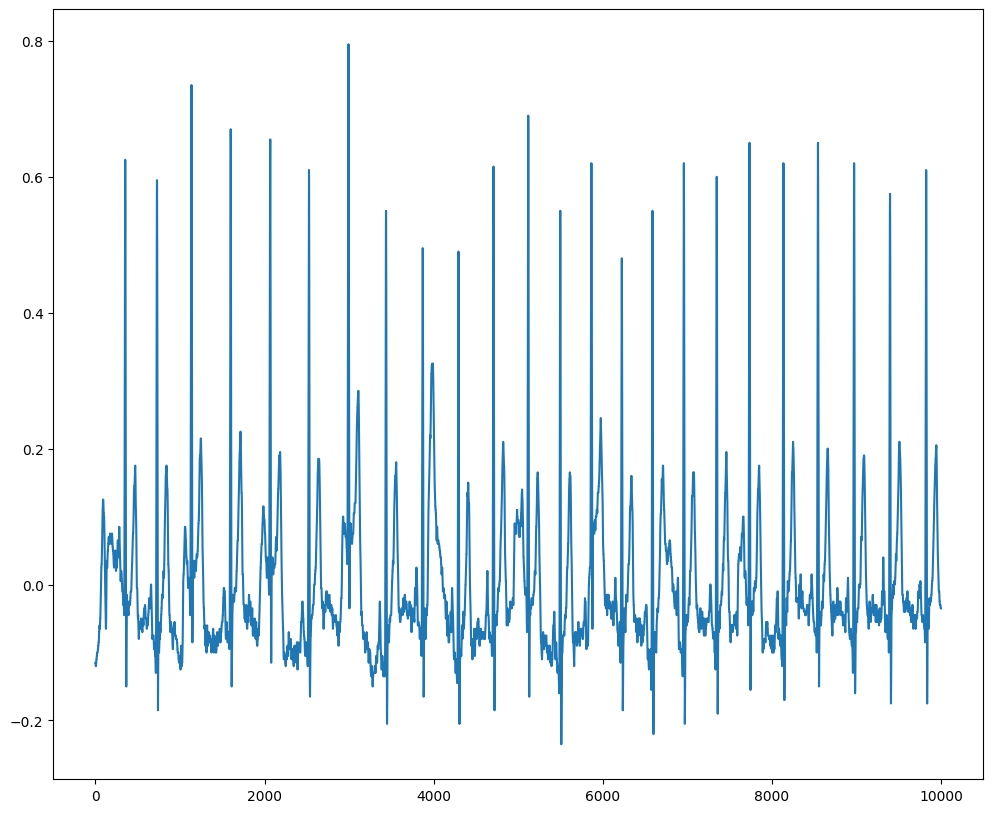

In [4]:
plt.figure(figsize=(12, 10))
ecg_data.plot()

Text(0.5, 1.0, '15 Seconds of ECG')

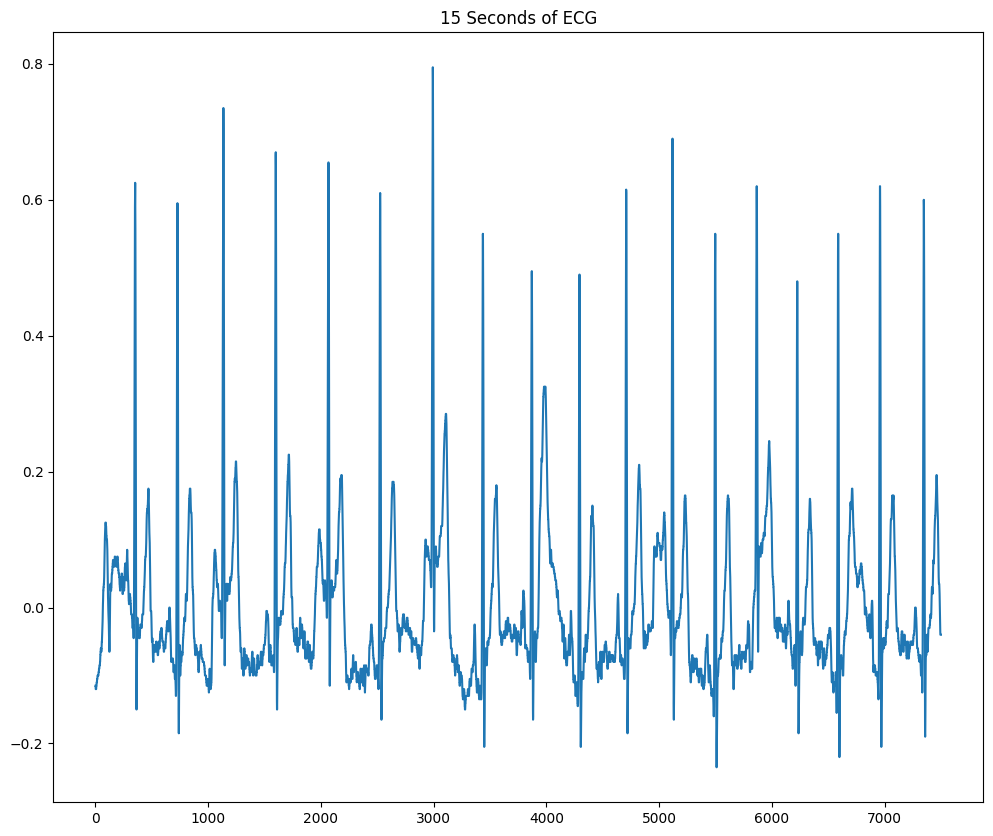

In [5]:
ecg_15_seconds = ecg_data[:7500]

plt.figure(figsize=(12, 10))
ecg_15_seconds.plot()
plt.title("15 Seconds of ECG")

In [6]:
peaks, _ = scipy.signal.find_peaks(ecg_15_seconds, height=0.45)
peaks = peaks + 0
peaks

array([ 352,  727, 1134, 1599, 2066, 2525, 2992, 3436, 3870, 4293, 4707,
       5118, 5497, 5865, 6224, 6587, 6958, 7347])

Text(0.5, 1.0, '15 Seconds ECG With R waves Labeled')

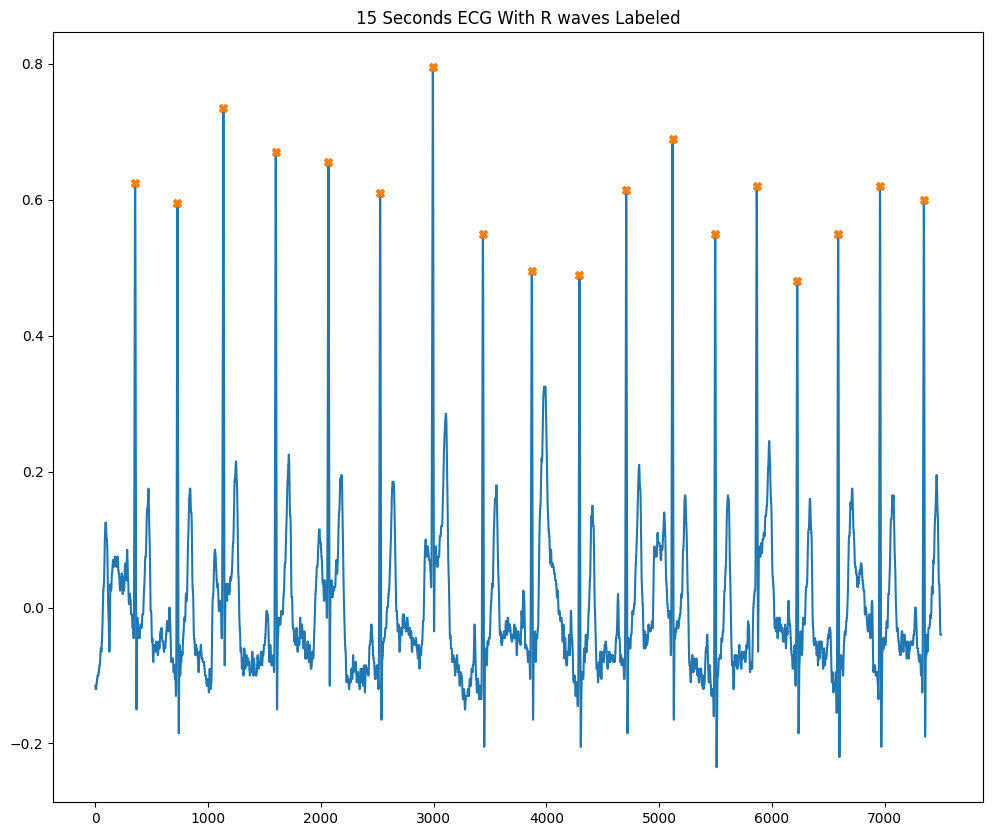

In [7]:
plt.figure(figsize=(12, 10))

ecg_15_seconds.plot()
plt.plot(peaks, ecg_15_seconds[peaks], "X")
plt.title("15 Seconds ECG With R waves Labeled")

### Making sure peaks are not falsely marked

In the graph above, some data points that are above the threshold are falsely marked as R waves. We can tell SciPy to only mark peaks that are a certain distance apart horizontally, since R waves can only happen so closely together.

The theoretical limit for heart rate in humans is 300 bpm, though there is also evidence of heart rates of 480 bpm and 600 bpm in rare medical cases. At this extreme upper limit of 600 bpm, that would mean that the fastest human heart rate every would happen 10 times per second. For our dataset, which has 360 data points per second (360 Hz), the fastest human heart rate would have peaks at most every 36 data points (360 Hz / 10 beats per second). Therefor, we can tell SciPy to only capture R wave peaks every 36 data points apart and still capture extreme medical anomalies.

We'll use distance=36 to tell SciPy the minimum distance R waves must be from each other.


In [8]:
peaks, _ = scipy.signal.find_peaks(ecg_15_seconds, height=0.45, distance=36)
peaks = peaks + 0
peaks

array([ 352,  727, 1134, 1599, 2066, 2525, 2992, 3436, 3870, 4293, 4707,
       5118, 5497, 5865, 6224, 6587, 6958, 7347])

Text(0.5, 1.0, '15 Seconds ECG With R waves Labeled')

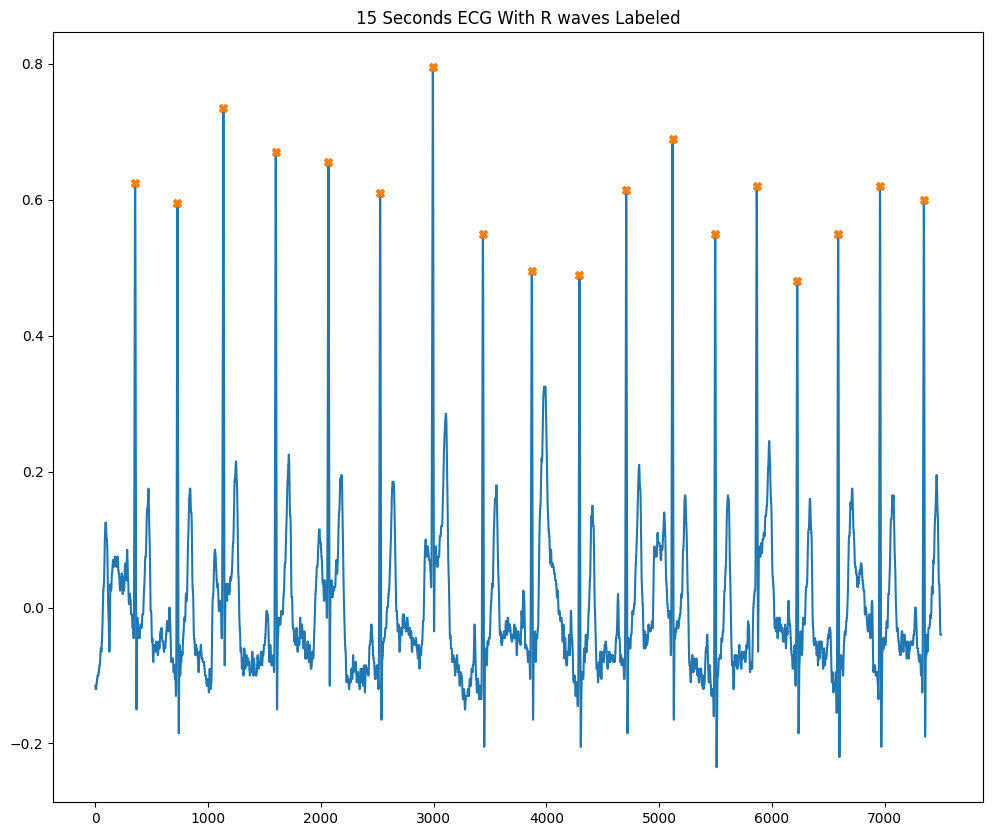

In [9]:
plt.figure(figsize=(12, 10))

ecg_15_seconds.plot()
plt.plot(peaks, ecg_15_seconds[peaks], "X")
plt.title("15 Seconds ECG With R waves Labeled")

## Measuring the Heart Rate

Heart rate is typically measured in 6-10 second chunks then multiplied to get the beats per minute. We can do this with our ECG data by counting the number of R waves in a 6-10 second chunk, since R waves are heartbeats.

For example, if there are 12 R waves in our 10-second chunk of the EKG, then we multiply the heart rate (12) by the number of 10-second chunks in a minute (6) to get our BPM. 12 heartbeats * 6 = 72 bpm. On the corollary, if we take a 6-second chunk, we'll multiply the heart beats by 10 so that the full count is calculated for 60 seconds.

We don't want to choose too large of a chunk to calculate the heart rate (a minute, for example), since heart rate can change rapidly in a medical setting. Rapid changes need to be seen and alerted on in seconds.

Text(0.5, 1.0, '6 seconds of ECG data')

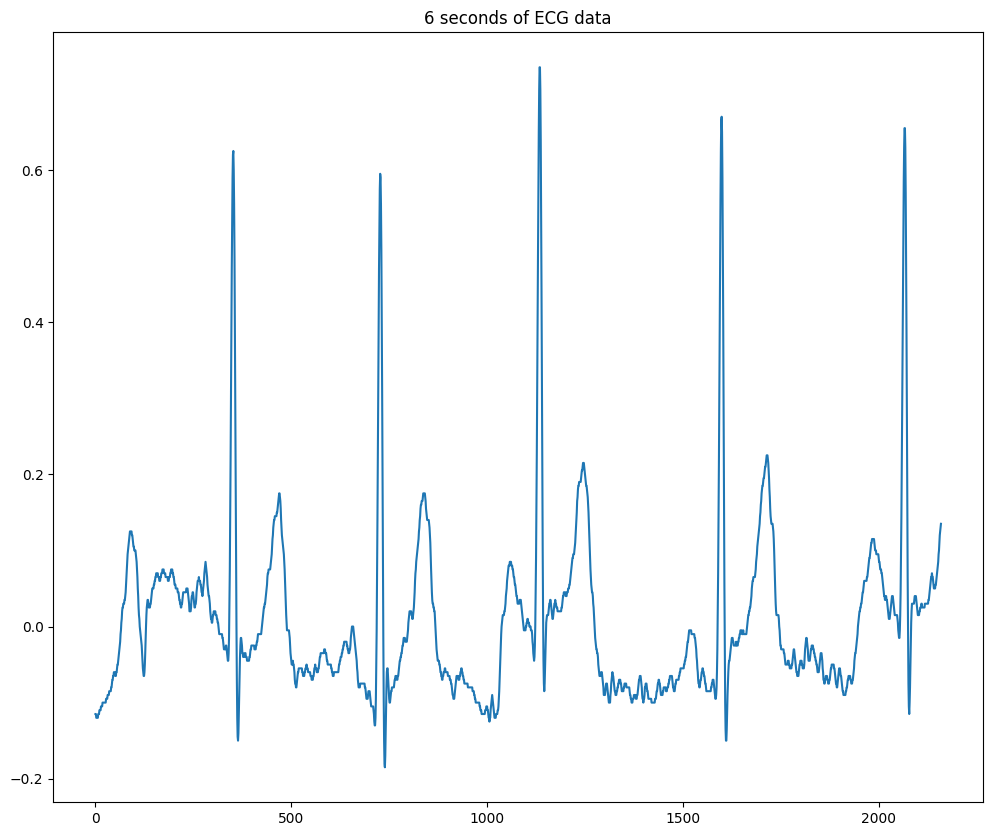

In [10]:
six_seconds_end_index = 6 * 360

plt.figure(figsize=(12, 10))
ecg_6_seconds = ecg_data[: + six_seconds_end_index]
ecg_6_seconds.plot()
plt.title("6 seconds of ECG data")

In [11]:
peaks, _ = scipy.signal.find_peaks(ecg_6_seconds, height=0.45, distance=36)
peaks = peaks + 0 # Adjust index to start at 0, the same as `ecg_6_seconds`
peaks

array([ 352,  727, 1134, 1599, 2066])

In [12]:
heart_rate = len(peaks) * 10
heart_rate

50

Text(0.5, 1.0, '6-second EKG with R waves labeled')

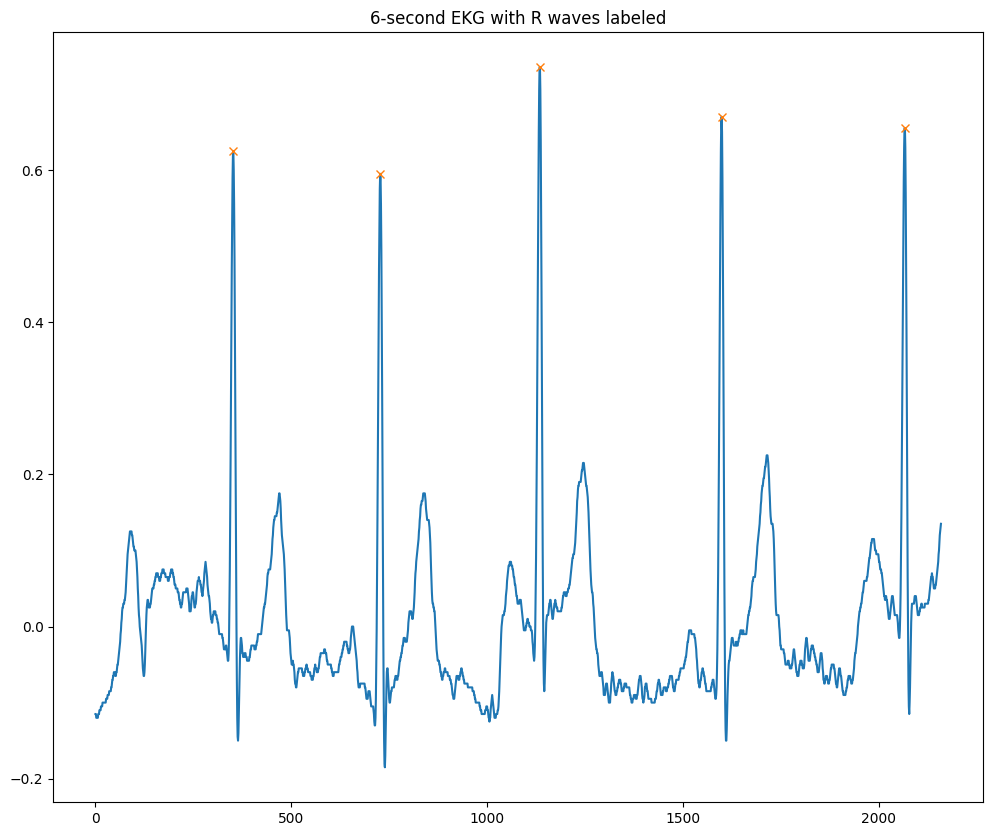

In [13]:
plt.figure(figsize=(12, 10))
ecg_6_seconds.plot()
plt.plot(peaks, ecg_6_seconds[peaks], "x")
plt.title("6-second EKG with R waves labeled")

# Full Dataset

In [14]:
smoothed_heartbeats = scipy.signal.savgol_filter(ecg_data, window_length=20, polyorder=2)

In [15]:
# Find the R waves' peaks
r_waves, metadata = scipy.signal.find_peaks(ecg_data, height=0.4)

In [20]:
p_waves = []
q_waves = []
s_waves = []
t_waves = []

waves_list = []

In [17]:
index_range = len(smoothed_heartbeats) - 1 # helps us not overshoot last element's index
r_waves_indexed = enumerate(r_waves)       # adds a separate index number to each R wave

# Create a DataFrame to store labeled waves
waves_df = pd.DataFrame(columns=['time', 'p', 'q', 'r', 's', 't'])

In [18]:
# Total time duration (in seconds)
total_duration = 20

# Total number of data points
total_data_points = 10000

# Calculate the time increment per data point
time_increment = total_duration / total_data_points

# Time values based on the index
time_values = np.arange(len(ecg_data)) * time_increment

In [21]:
# Loop through the RR intervals
for (index, r) in r_waves_indexed:
    # Get the RR interval
    start_index = r                    # the index of the current R wave
    try:
        end_index = r_waves[index + 1] # the index of the next R wave
    except IndexError:
        end_index = index_range        # have hit the end of the heartbeat array
    temp_rr_interval = smoothed_heartbeats[start_index:end_index]

    # Label the P and T waves
    p_and_t_waves, metadata = scipy.signal.find_peaks(temp_rr_interval,
                                                      height=[-0.1, 0.325],
                                                      distance=200)
    p_wave = p_and_t_waves[-1]
    t_wave = p_and_t_waves[0]

    # Label the Q wave
    q_area = temp_rr_interval[-16:]
    q_area = pd.Series(q_area)
    q_wave = q_area.idxmin(axis=0)

    # Label the S wave
    s_area = temp_rr_interval[0:16]
    s_area = pd.Series(s_area)
    s_wave = s_area.idxmin(axis=0)
    
    '''Increment index all of the newly found waves, since each for loop
    causes the RR interval's index to start at 0. For example, if the 2nd RR
    interval's Q wave is found at index 12, yet that RR interval actually
    starts at 100, then the Q wave's actual index is 112.
    '''
    p_wave += r
    q_wave += r + len(temp_rr_interval) - 15
    s_wave += r
    t_wave += r

    # Calculate time for the QRS complex
    qrs_start_time = time_values[start_index]

    # Add the waves to the DataFrame
    waves_list.append({
        'time': qrs_start_time,
        'p': p_wave,
        'q': q_wave,
        'r': r,
        's': s_wave,
        't': t_wave
    })

In [22]:
waves_df = pd.DataFrame(waves_list)

In [24]:
print(waves_df)

      time     p     q     r     s     t
0    1.454  1059  1119   727   740   837
1    2.268  1520  1584  1134  1147  1245
2    3.198  1985  2051  1599  1611  1714
3    4.132  2447  2510  2066  2079  2181
4    5.050  2927  2977  2525  2538  2639
5    5.984  3363  3421  2992  3005  3107
6    6.872  3797  3855  3436  3449  3555
7    7.740  4217  4278  3870  3882  3987
8    8.586  4634  4693  4293  4306  4406
9    9.414  5045  5104  4707  4720  4820
10  10.236  5448  5483  5118  5131  5229
11  10.994  5844  5850  5497  5510  5612
12  11.730  6199  6210  5865  5877  5975
13  12.448  6337  6573  6224  6237  6337
14  13.174  6929  6944  6587  6600  6711
15  13.916  7312  7332  6958  6971  7074
16  14.694  7661  7720  7347  7360  7460
17  15.470  8065  8121  7735  7747  7848
18  16.272  8470  8530  8136  8149  8250
19  17.090  8898  8957  8545  8558  8660
20  17.944  9317  9382  8972  8985  9087
21  18.794  9753  9809  9397  9409  9507
22  19.648  9942  9998  9824  9837  9942


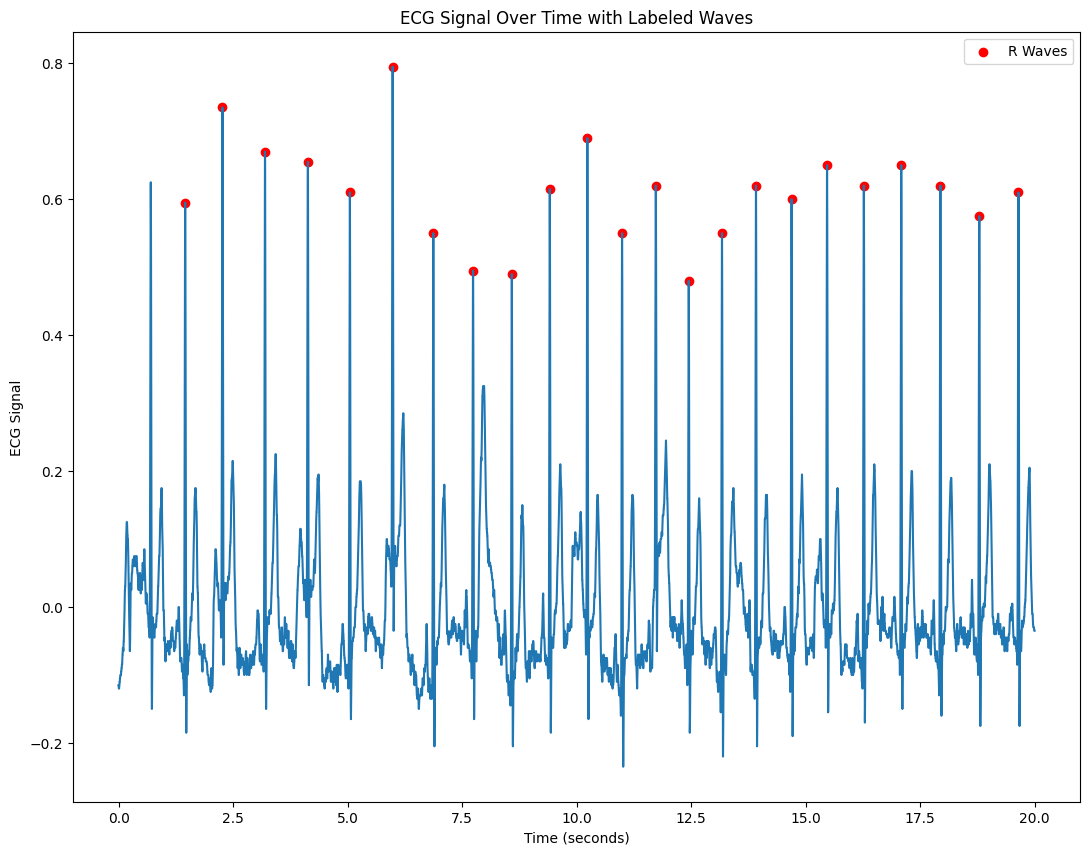

In [25]:
plt.figure(figsize=(13, 10))
plt.plot(time_values, ecg_data)
plt.scatter(waves_df['time'], ecg_data[waves_df['r'].astype(int)], color='red', label='R Waves')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Signal')
plt.title('ECG Signal Over Time with Labeled Waves')
plt.legend()
plt.show()

## Graph the PQST Waves

In [ ]:
plt.figure(figsize=(13, 10))

pd.Series(ecg_data).plot()
plt.plot(p_waves, ecg_data[p_waves], "x", label="P waves")
plt.plot(q_waves, ecg_data[q_waves], "x", label="Q waves")
plt.plot(r_waves, ecg_data[r_waves], "x", label="R waves")
plt.plot(s_waves, ecg_data[s_waves], "x", label="S waves")
plt.plot(t_waves, ecg_data[t_waves], "x", label="T waves")
plt.legend()
plt.title("All Waves Labeled")
plt.show()